In [1]:
import scanpy as sc
import pandas as pd

import os
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.simplefilter(action='ignore', category=UserWarning)

import scanpy as sc
import torch
import scarches as sca
from scarches.dataset.trvae.data_handling import remove_sparsity
import matplotlib.pyplot as plt
import numpy as np
import gdown

sc.settings.set_figure_params(dpi=200, frameon=False)
sc.set_figure_params(dpi=200)
sc.set_figure_params(figsize=(6, 6))
torch.set_printoptions(precision=3, sci_mode=False, edgeitems=7)


In [2]:
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
print("[*] Selected device: ", device)


[*] Selected device:  cuda


In [3]:
AMB = sc.read_h5ad('human.h5ad')
AMB_m = sc.read_h5ad('mouse.h5ad')
AMB_mm = sc.read_h5ad('marmoset.h5ad')


Observation names are not unique. To make them unique, call `.obs_names_make_unique`.


In [4]:
AMB = AMB.concatenate((AMB_m, AMB_mm), 
                      batch_categories=['human','mouse', 'marmoset'])



Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
Observation names are not unique. To make them unique, call `.obs_names_make_unique`.


In [5]:
del AMB_m, AMB_mm

In [6]:
target_conditions = ['human']

In [7]:
source_adata = AMB[~AMB.obs.batch.isin(target_conditions)].copy()
target_adata = AMB[AMB.obs.batch.isin(target_conditions)].copy()
print(source_adata)
print(target_adata)


Observation names are not unique. To make them unique, call `.obs_names_make_unique`.


AnnData object with n_obs × n_vars = 229018 × 27466
    obs: 'Class', 'Subclass', 'RNA_cluster', 'Cross_species', 'batch'
AnnData object with n_obs × n_vars = 76621 × 27466
    obs: 'Class', 'Subclass', 'RNA_cluster', 'Cross_species', 'batch'


In [8]:
del AMB

In [9]:
source_adata.raw = source_adata

In [10]:
sc.pp.highly_variable_genes(
    source_adata,
    n_top_genes=2000,
    batch_key="batch",
    subset=True)


... storing 'Class' as categorical
... storing 'Subclass' as categorical
... storing 'RNA_cluster' as categorical
... storing 'Cross_species' as categorical
/exports/humgen/lmichielsen/miniconda3/envs/scarches/lib/python3.7/site-packages/pandas-1.3.0-py3.7-linux-x86_64.egg/pandas/core/indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)
Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
Observation names are not unique. To make them unique, call `.obs_names_make_unique`.


In [11]:
source_adata.X = source_adata.raw[:, source_adata.var_names].X

### SCVI model

In [12]:
sca.dataset.setup_anndata(source_adata, batch_key="batch")


INFO     Using batches from adata.obs["batch"]                                               
INFO     No label_key inputted, assuming all cells have same label                           
INFO     Using data from adata.X                                                             
INFO     Computing library size prior per batch                                              
INFO     Successfully registered anndata object containing 229018 cells, 2000 vars, 2        
         batches, 1 labels, and 0 proteins. Also registered 0 extra categorical covariates   
         and 0 extra continuous covariates.                                                  
INFO     Please do not further modify adata until model is trained.                          


In [13]:
early_stopping_kwargs = {
    "early_stopping_metric": "elbo",
    "save_best_state_metric": "elbo",
    "patience": 10,
    "threshold": 0,
    "reduce_lr_on_plateau": True,
    "lr_patience": 8,
    "lr_factor": 0.1
}


In [14]:
vae = sca.models.SCVI(
    source_adata,
    n_layers=2,
    encode_covariates=True,
    deeply_inject_covariates=True,
    use_layer_norm="both",
    use_batch_norm="none",
)


WARNING  Make sure the registered X field in anndata contains unnormalized count data.       


In [15]:
vae.train(n_epochs=500, frequency=1, lr=0.001,
          early_stopping_kwargs=early_stopping_kwargs)


INFO     Training for 500 epochs                                                             
INFO     KL warmup for 400 epochs                                                            
Training...:  85%|████████████████████████████     | 425/500 [2:06:08<22:39, 18.13s/it]INFO                                                                                         
         Stopping early: no improvement of more than 0 nats in 10 epochs                     
INFO     If the early stopping criterion is too strong, please instantiate it with different 
         parameters in the train method.                                                     
Training...:  85%|████████████████████████████     | 425/500 [2:06:26<22:18, 17.85s/it]
INFO     Training time:  5041 s. / 500 epochs                                                


In [16]:
reference_latent = sc.AnnData(vae.get_latent_representation())
reference_latent.obs["batch"] = source_adata.obs["batch"].tolist()
reference_latent.obs["Class"] = source_adata.obs["Class"].tolist()
reference_latent.obs["Subclass"] = source_adata.obs["Subclass"].tolist()
reference_latent.obs["RNA_cluster"] = source_adata.obs["RNA_cluster"].tolist()
reference_latent.obs["Cross_species"] = source_adata.obs["Cross_species"].tolist()


WARNING  Make sure the registered X field in anndata contains unnormalized count data.       


In [17]:
sc.pp.neighbors(reference_latent, n_neighbors=8)
sc.tl.leiden(reference_latent)
sc.tl.umap(reference_latent)


... storing 'batch' as categorical
... storing 'Class' as categorical
... storing 'Subclass' as categorical
... storing 'RNA_cluster' as categorical
... storing 'Cross_species' as categorical


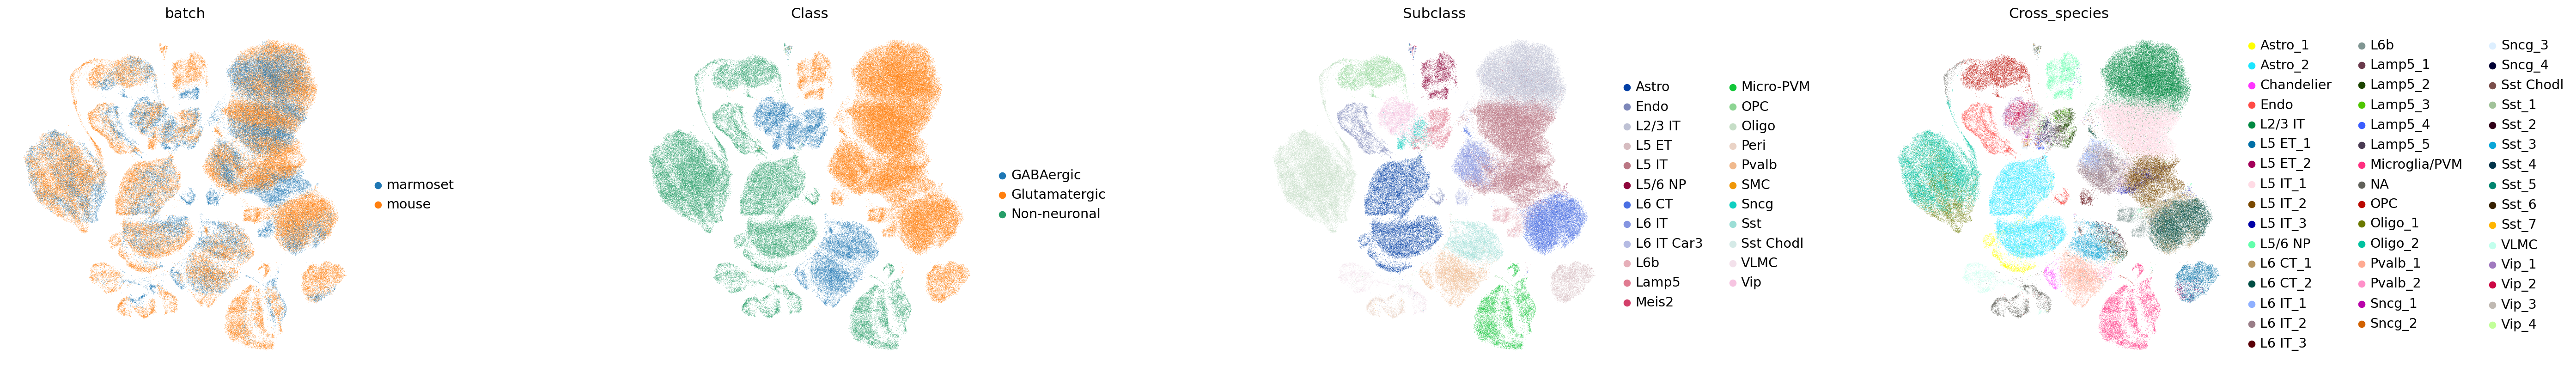

In [18]:
sc.pl.umap(reference_latent,
           color=['batch', 'Class', 'Subclass', 'Cross_species'],
           frameon=False,
           wspace=0.6,
           )


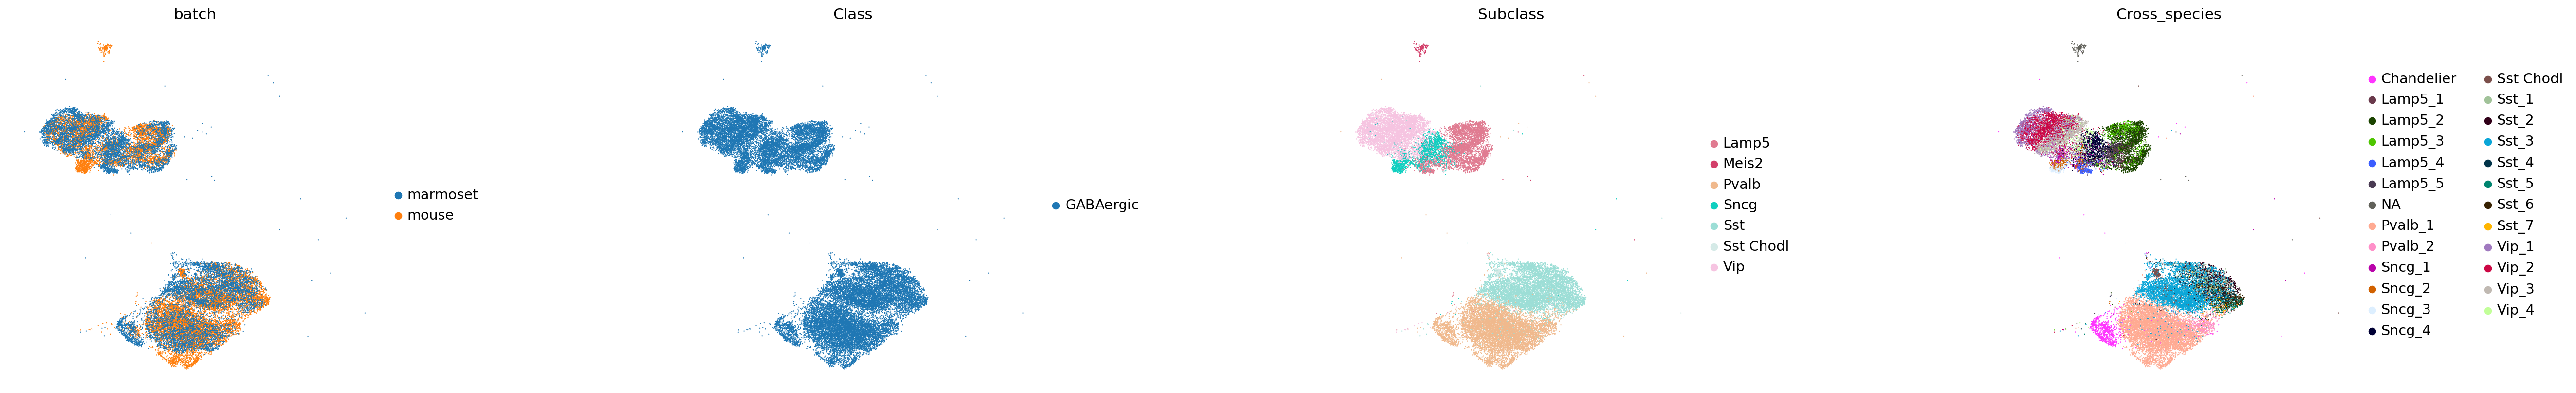

In [19]:
idx = np.where(reference_latent.obs['Class'] == 'GABAergic')[0]
sc.pl.umap(reference_latent[idx],
           color=['batch', 'Class', 'Subclass', 'Cross_species'],
           frameon=False,
           wspace=0.6,
           )


In [20]:
ref_path = 'ref_model_AMB_scHPL/'
vae.save(ref_path, overwrite=True)

### Construct hierarchy for reference using scHPL

Use only GABAergic neurons for now, to make it more clear

In [21]:
idx = np.where(reference_latent.obs['Class'] == 'GABAergic')[0]
reference_latent_GABA = reference_latent[idx]

# idx = np.where(reference_latent.obs['Class'] == 'Glutamatergic')[0]
# reference_latent_Gluta = reference_latent[idx]

In [22]:
reference_latent_GABA.obs['subclass_batch'] = np.char.add(np.array(reference_latent_GABA.obs['Subclass'], dtype= str),
                                             np.array(reference_latent_GABA.obs['batch'], dtype=str))
reference_latent_GABA.obs['cluster_batch'] = np.char.add(np.array(reference_latent_GABA.obs['RNA_cluster'], dtype= str),
                                             np.array(reference_latent_GABA.obs['batch'], dtype=str))

# reference_latent_Gluta.obs['subclass_batch'] = np.char.add(np.array(reference_latent_Gluta.obs['Subclass'], dtype= str),
#                                              np.array(reference_latent_Gluta.obs['batch'], dtype=str))
# reference_latent_Gluta.obs['cluster_batch'] = np.char.add(np.array(reference_latent_Gluta.obs['RNA_cluster'], dtype= str),
#                                              np.array(reference_latent_Gluta.obs['batch'], dtype=str))

# reference_latent.obs['subclass_batch'] = np.char.add(np.array(reference_latent.obs['Subclass'], dtype= str),
#                                              np.array(reference_latent.obs['batch'], dtype=str))
# reference_latent.obs['cluster_batch'] = np.char.add(np.array(reference_latent.obs['RNA_cluster'], dtype= str),
#                                              np.array(reference_latent.obs['batch'], dtype=str))


Trying to set attribute `.obs` of view, copying.


Starting tree:


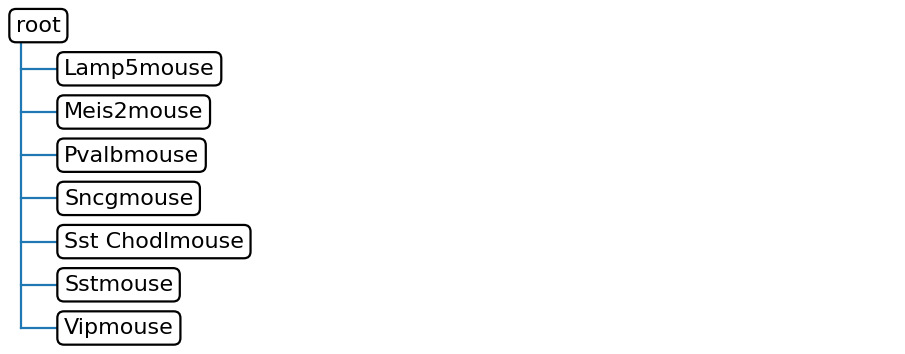


Adding dataset marmoset to the tree
Normalized CM
ypred           Distance rejection  Lamp5marmoset  Pvalbmarmoset  \
ytrue                                                              
Lamp5mouse                0.024617       0.766344       0.000000   
Meis2mouse                0.854167       0.000000       0.000000   
Pvalbmouse                0.063071       0.000176       0.885102   
Sncgmouse                 0.307692       0.012522       0.000000   
Sst Chodlmouse            0.609756       0.000000       0.000000   
Sstmouse                  0.030822       0.000000       0.004892   
Vipmouse                  0.049823       0.007774       0.000353   

ypred           Sncgmarmoset  Sstmarmoset  Vipmarmoset     root2  
ytrue                                                             
Lamp5mouse          0.159403     0.000404     0.005246  0.043987  
Meis2mouse          0.000000     0.000000     0.031250  0.114583  
Pvalbmouse          0.000000     0.045327     0.000351  0.005973  
S

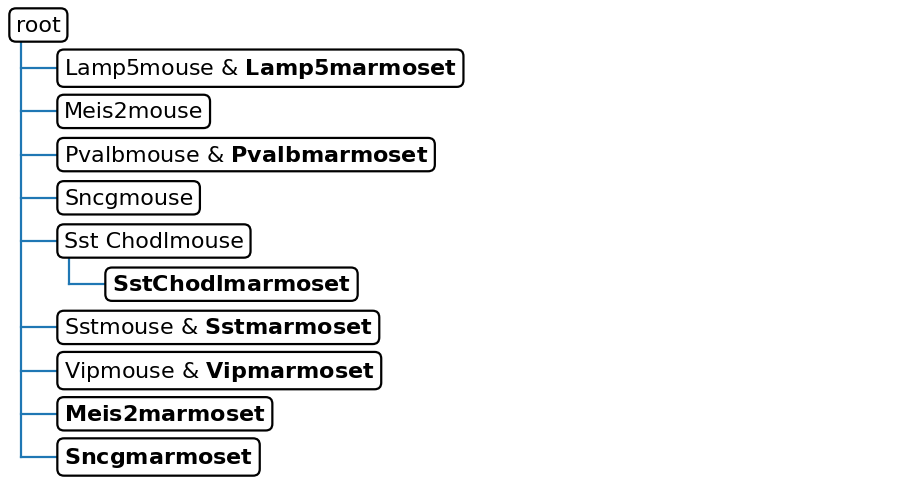

In [23]:
tree_subclass_ref, mp_subclass_ref = sca.classifiers.learn_tree(data = reference_latent_GABA, 
                batch_key = 'batch',
                batch_order = ['mouse', 'marmoset'],
                cell_type_key='subclass_batch',
                classifier = 'knn',
                dimred = False)


... storing 'subclass_batch' as categorical
... storing 'cluster_batch' as categorical


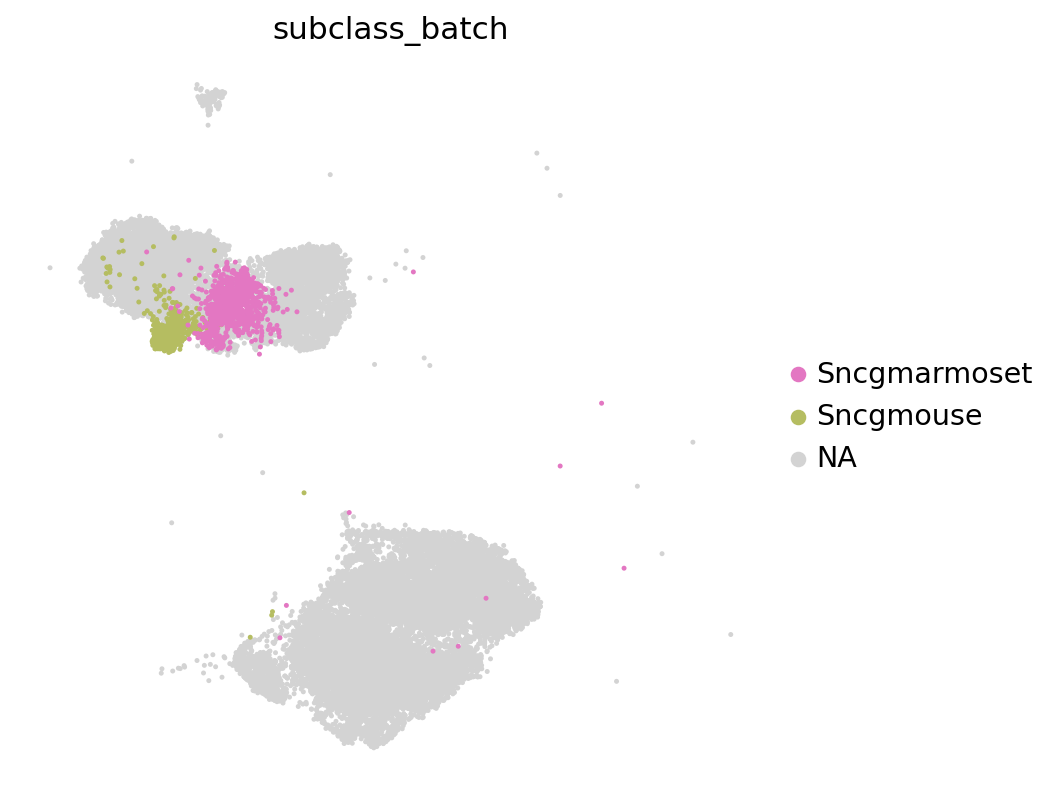

In [24]:
# idx = np.where(reference_latent.obs['Class'] == 'GABAergic')[0]


sc.pl.umap(reference_latent_GABA,
           color=['subclass_batch'],
           groups=['Sncgmarmoset','Sncgmouse'],
           frameon=False,
           wspace=0.6,
           s=20
           )


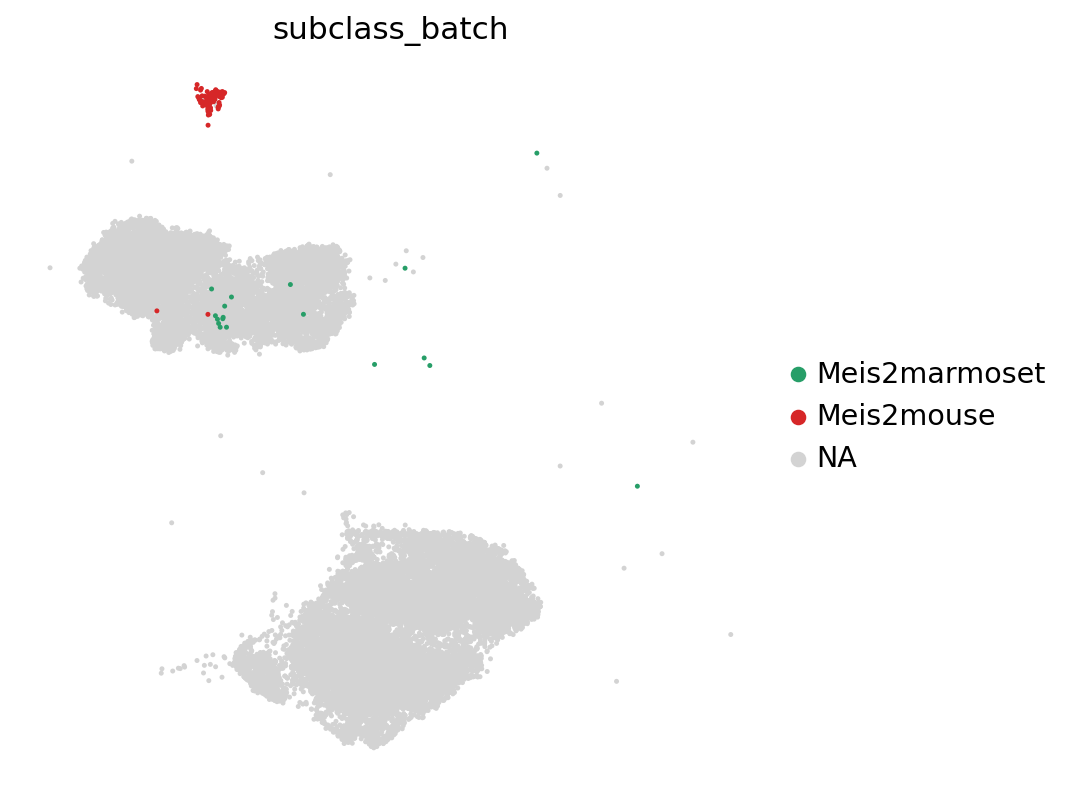

In [25]:
sc.pl.umap(reference_latent_GABA,
           color=['subclass_batch'],
           groups=['Meis2marmoset','Meis2mouse'],
           frameon=False,
           wspace=0.6,
           s=20
           )


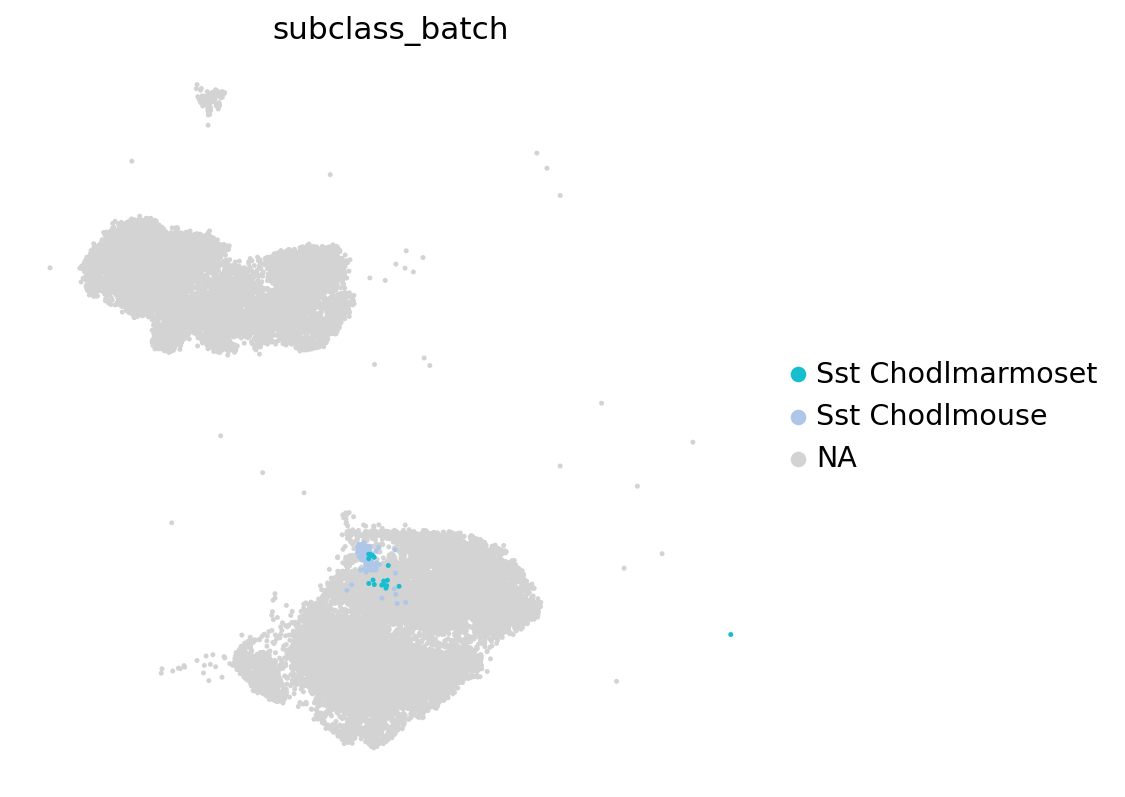

In [26]:
sc.pl.umap(reference_latent_GABA,
           color=['subclass_batch'],
           groups=['Sst Chodlmarmoset','Sst Chodlmouse'],
           frameon=False,
           wspace=0.6,
           s=20
           )

In [27]:
obs_gaba = source_adata.obs.iloc[np.where(source_adata.obs['Class'] == 'GABAergic')[0]]

obs_gaba.groupby(['Cross_species', 'batch', 'Subclass']).count()[np.sum(obs_gaba.groupby(['Cross_species', 'batch', 'Subclass']).count(), axis=1) != 0]

Class  RNA_cluster  _scvi_batch  \
Cross_species batch    Subclass                                     
Chandelier    mouse    Pvalb        160          160          160   
              marmoset Pvalb        591          591          591   
Lamp5_1       mouse    Lamp5        252          252          252   
              marmoset Lamp5         93           93           93   
Lamp5_2       mouse    Lamp5       1464         1464         1464   
              marmoset Lamp5        711          711          711   
Lamp5_3       mouse    Lamp5        148          148          148   
              marmoset Lamp5        280          280          280   
Lamp5_4       mouse    Lamp5        112          112          112   
              marmoset Lamp5        228          228          228   
Lamp5_5       mouse    Lamp5        406          406          406   
              marmoset Lamp5        161          161          161   
NA            mouse    Meis2         96           96           96   
              marmoset Meis2         18           18           18   
Pvalb_1       mouse    Pvalb       5083         5083         5083   
                       Sst           21           21           21   
              marmoset Pvalb       1996         1996         1996   
Pvalb_2       mouse    Pvalb        449          449          449   
              marmoset Pvalb         98           98           98   
Sncg_1        mouse    Sncg          81           81           81   
                       Vip          135          135          135   
              marmoset Sncg         122          122          122   
Sncg_2        mouse    Sncg         205          205          205   
              marmoset Sncg         113          113          113   
Sncg_3        mouse    Sncg         273          273          273   
              marmoset Sncg          98           98           98   
Sncg_4        mouse    Lamp5         96           96           96   
              marmoset Sncg         627          627          627   
Sst Chodl     mouse    Sst Chodl    164          164          164   
              marmoset Sst           48           48           48   
                       Sst Chodl     19           19           19   
Sst_1         mouse    Sst          318          318          318   
              marmoset Sst          255          255          255   
Sst_2         mouse    Sst          718          718          718   
              marmoset Sst          152          152          152   
Sst_3         mouse    Sst         2277         2277         2277   
              marmoset Sst         2144         2144         2144   
Sst_4         mouse    Sst          214          214          214   
              marmoset Sst          209          209          209   
Sst_5         mouse    Sst          189          189          189   
              marmoset Sst          111          111          111   
Sst_6         mouse    Sst          281          281          281   
              marmoset Sst          186          186          186   
Sst_7         mouse    Sst           70           70           70   
              marmoset Sst           54           54           54   
Vip_1         mouse    Vip          891          891          891   
              marmoset Vip          724          724          724   
Vip_2         mouse    Vip         1080         1080         1080   
              marmoset Vip          925          925          925   
Vip_3         mouse    Vip          395          395          395   
              marmoset Vip          783          783          783   
Vip_4         mouse    Vip          329          329          329   
              marmoset Vip          192          192          192   

                                  _scvi_labels  _scvi_local_l_mean  \
Cross_species batch    Subclass                                      
Chandelier    mouse    Pvalb               160                 160   
              marmoset Pvalb

### Apply surgery with human dataset

In [28]:
target_adata = target_adata[:, source_adata.var_names]
target_adata


View of AnnData object with n_obs × n_vars = 76621 × 2000
    obs: 'Class', 'Subclass', 'RNA_cluster', 'Cross_species', 'batch'

In [29]:
model = sca.models.SCVI.load_query_data(
    target_adata,
    ref_path,
    freeze_dropout = True,
)


Trying to set attribute `.uns` of view, copying.


INFO     .obs[_scvi_labels] not found in target, assuming every cell is same category        
INFO     Using data from adata.X                                                             
INFO     Computing library size prior per batch                                              
INFO     Registered keys:['X', 'batch_indices', 'local_l_mean', 'local_l_var', 'labels']     
INFO     Successfully registered anndata object containing 76621 cells, 2000 vars, 3 batches,
         1 labels, and 0 proteins. Also registered 0 extra categorical covariates and 0 extra
         continuous covariates.                                                              
WARNING  Make sure the registered X field in anndata contains unnormalized count data.       


In [30]:
early_stopping_kwargs = {
    "early_stopping_metric": "elbo",
    "save_best_state_metric": "elbo",
    "patience": 10,
    "threshold": 0,
    "reduce_lr_on_plateau": True,
    "lr_patience": 8,
    "lr_factor": 0.1
}


In [31]:
model.train(n_epochs=100, frequency=1, early_stopping_kwargs=early_stopping_kwargs)


INFO     Training for 100 epochs                                                             
INFO     KL warmup phase exceeds overall training phaseIf your applications rely on the      
         posterior quality, consider training for more epochs or reducing the kl warmup.     
INFO     KL warmup for 400 epochs                                                            
Training...: 100%|███████████████████████████████████| 100/100 [09:52<00:00,  5.93s/it]
INFO     Training is still in warming up phase. If your applications rely on the posterior   
         quality, consider training for more epochs or reducing the kl warmup.               
INFO     Training time:  378 s. / 100 epochs                                                 


In [32]:
query_latent = sc.AnnData(model.get_latent_representation())
query_latent.obs["batch"] = target_adata.obs["batch"].tolist()
query_latent.obs["Class"] = target_adata.obs["Class"].tolist()
query_latent.obs["Subclass"] = target_adata.obs["Subclass"].tolist()
query_latent.obs["RNA_cluster"] = target_adata.obs["RNA_cluster"].tolist()
query_latent.obs["Cross_species"] = target_adata.obs["Cross_species"].tolist()


WARNING  Make sure the registered X field in anndata contains unnormalized count data.       


In [33]:
surgery_path = 'surgery_model'
model.save(surgery_path, overwrite=True)


In [34]:
full_latent = reference_latent.concatenate(query_latent,
                                           batch_key = 'ref_query')

... storing 'batch' as categorical
... storing 'Class' as categorical
... storing 'Subclass' as categorical
... storing 'RNA_cluster' as categorical
... storing 'Cross_species' as categorical


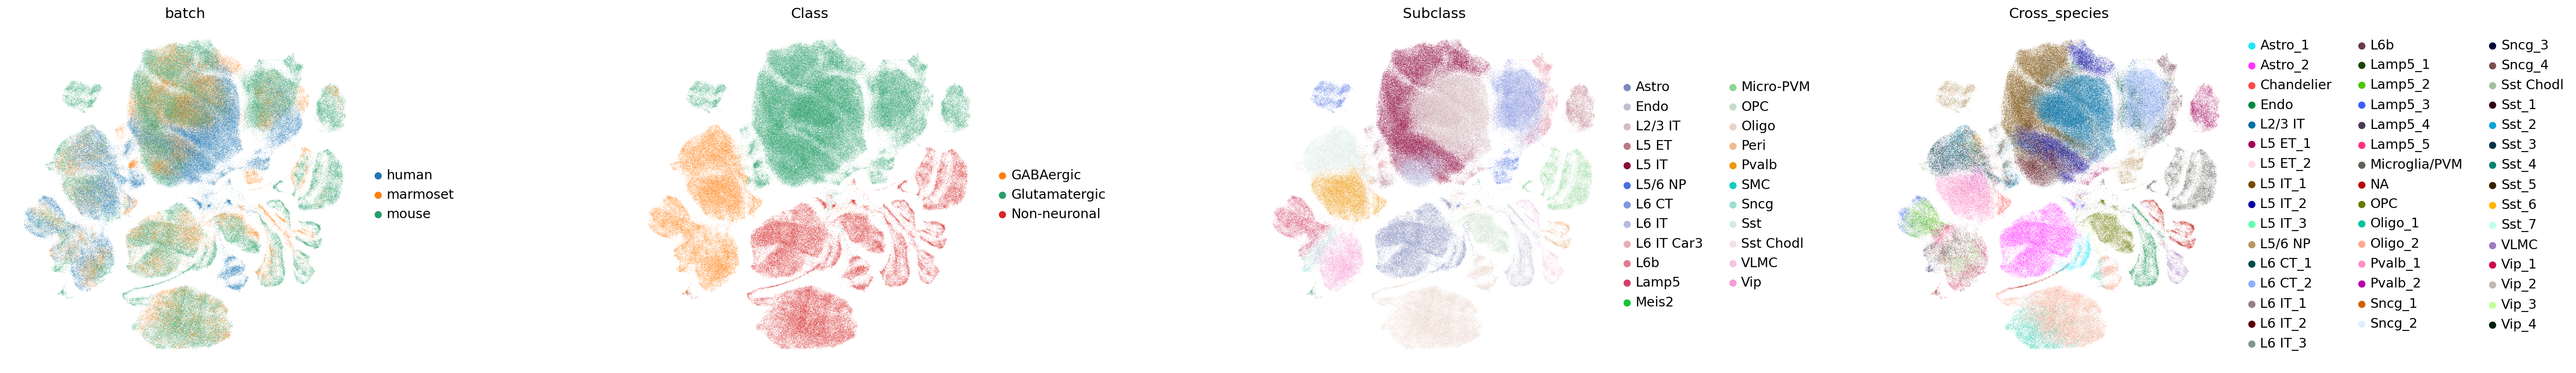

In [35]:
sc.pp.neighbors(full_latent, n_neighbors=8)
sc.tl.leiden(full_latent)
sc.tl.umap(full_latent)
sc.pl.umap(full_latent,
           color=['batch', 'Class', 'Subclass', 'Cross_species'],
           frameon=False,
           wspace=0.6,
           )


### Add human dataset to the tree

In [36]:
idx = np.where(full_latent.obs['Class'] == 'GABAergic')[0]
full_latent_GABA = full_latent[idx]

# idx = np.where(full_latent.obs['Class'] == 'Glutamatergic')[0]
# full_latent_Gluta = full_latent[idx]

In [37]:
full_latent_GABA.obs['subclass_batch'] = np.char.add(np.array(full_latent_GABA.obs['Subclass'], dtype= str),
                                             np.array(full_latent_GABA.obs['batch'], dtype=str))
full_latent_GABA.obs['cluster_batch'] = np.char.add(np.array(full_latent_GABA.obs['RNA_cluster'], dtype= str),
                                             np.array(full_latent_GABA.obs['batch'], dtype=str))

# full_latent_Gluta.obs['subclass_batch'] = np.char.add(np.array(full_latent_Gluta.obs['Subclass'], dtype= str),
#                                              np.array(full_latent_Gluta.obs['batch'], dtype=str))
# full_latent_Gluta.obs['cluster_batch'] = np.char.add(np.array(full_latent_Gluta.obs['RNA_cluster'], dtype= str),
#                                              np.array(full_latent_Gluta.obs['batch'], dtype=str))

# full_latent.obs['subclass_batch'] = np.char.add(np.array(full_latent.obs['Subclass'], dtype= str),
#                                              np.array(full_latent.obs['batch'], dtype=str))
# full_latent.obs['cluster_batch'] = np.char.add(np.array(full_latent.obs['RNA_cluster'], dtype= str),
#                                              np.array(full_latent.obs['batch'], dtype=str))


Trying to set attribute `.obs` of view, copying.


Starting tree:


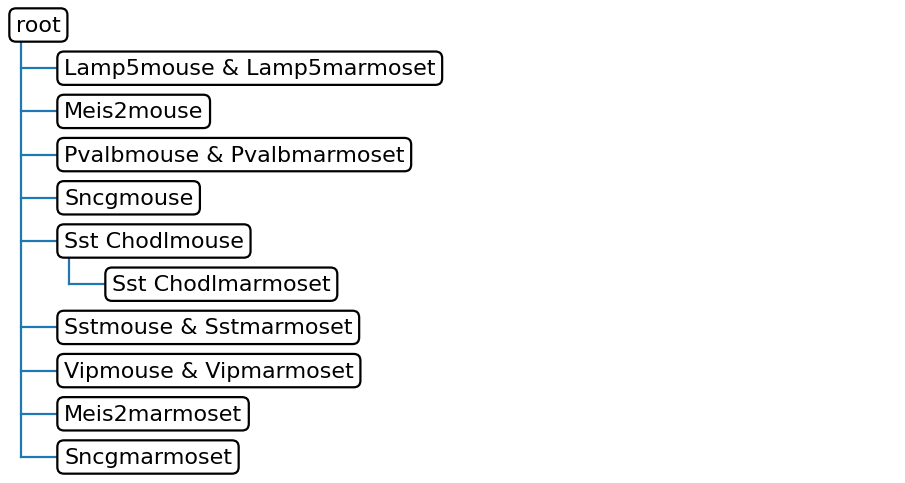


Adding dataset human to the tree
Normalized CM
ypred              Distance rejection  Lamp5human  Pvalbhuman  Sncghuman  \
ytrue                                                                      
Lamp5mouse                   0.013921    0.764870    0.000000   0.026576   
Meis2marmoset                0.000000    0.222222    0.000000   0.000000   
Meis2mouse                   0.000000    0.000000    0.000000   0.000000   
Pvalbmouse                   0.011341    0.000597    0.863197   0.000000   
Sncgmarmoset                 0.041667    0.083333    0.000000   0.416667   
Sncgmouse                    0.010733    0.003578    0.000000   0.008945   
Sst Chodlmarmoset            0.263158    0.000000    0.000000   0.000000   
Sst Chodlmouse               0.414634    0.000000    0.000000   0.000000   
Sstmouse                     0.038499    0.000000    0.030909   0.000000   
Vipmouse                     0.032453    0.007884    0.000550   0.030986   

ypred              Sst Chodlhuman  Ssth

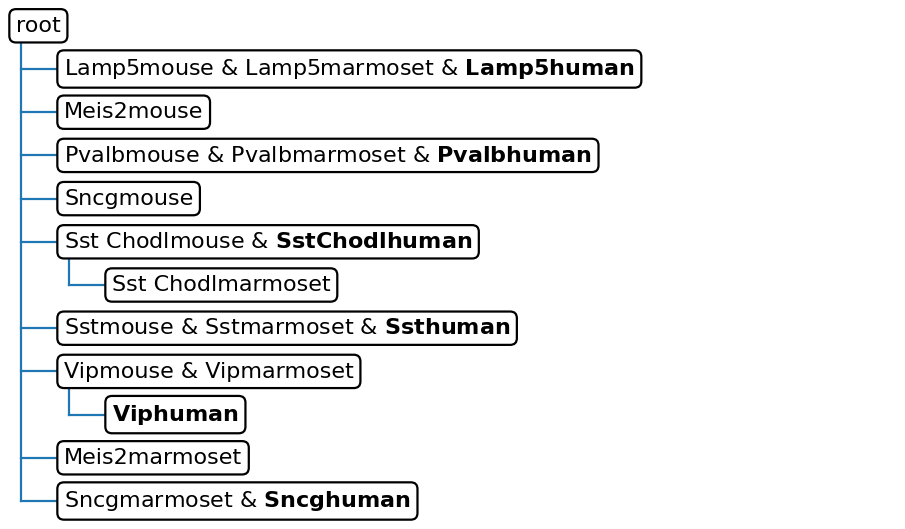

In [38]:
tree_subclass, mp_subclass = sca.classifiers.learn_tree(data = full_latent_GABA, 
                batch_key = 'batch',
                batch_added = ['mouse', 'marmoset'],
                batch_order = ['human'],
                cell_type_key='subclass_batch',
                retrain = False,
                tree = tree_subclass_ref,
                classifier = 'knn',
                dimred = False)

... storing 'subclass_batch' as categorical
... storing 'cluster_batch' as categorical


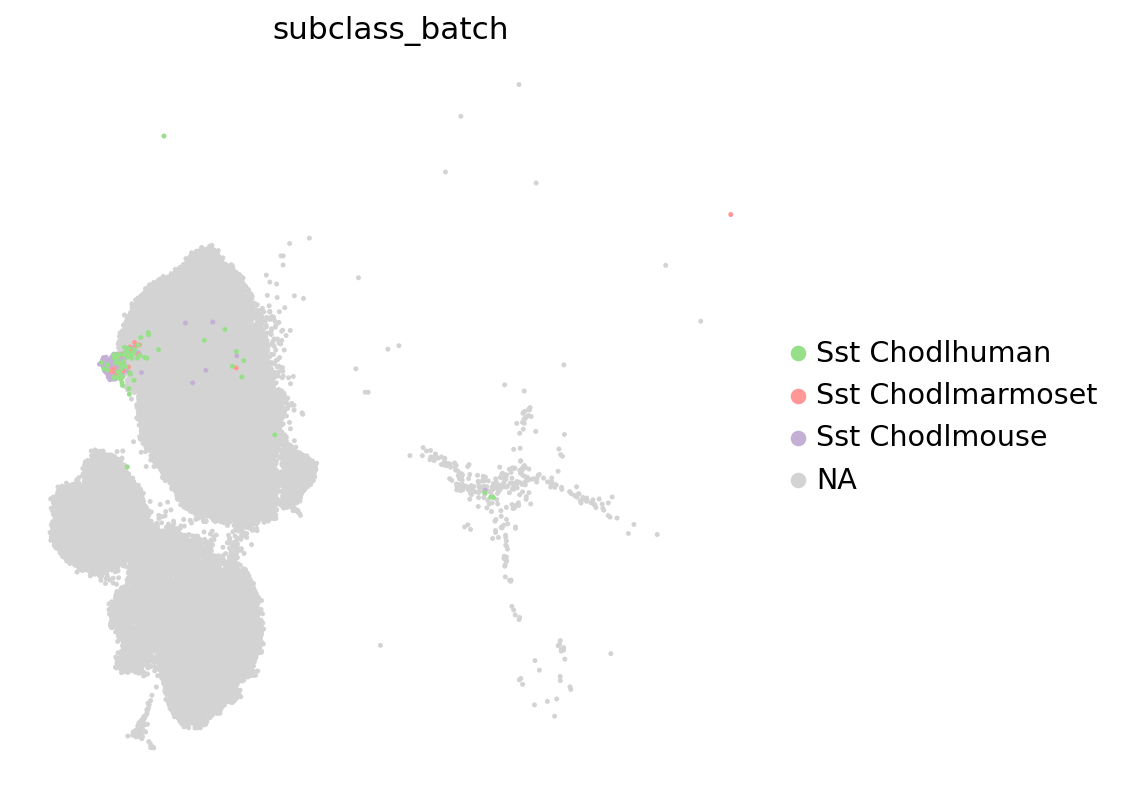

In [39]:
sc.pl.umap(full_latent_GABA,
           color=['subclass_batch'],
           groups=['Sst Chodlmarmoset','Sst Chodlmouse','Sst Chodlhuman'],
           frameon=False,
           wspace=0.6,
           s=20
           )
